In [1]:
'''
Here we will model a simple image, treating the network as a neural field:
the input space is x, y and the output space is 3 channel values
'''

'\nHere we will model a simple image, treating the network as a neural field:\nthe input space is x, y and the output space is 3 channel values\n'

In [3]:
import pathlib, sys

base_dir = pathlib.Path().resolve()        # notebook folder (simple_img/)
project_root = base_dir.parent            # repo root
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


In [4]:


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils import (
    ImageField,
    load_image_field,
    plot_training_snapshot,
    launch_interactive_inspector,
)

from spatialnet_model import SpatialNet

In [5]:

import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/home/matteo/Documents/spatial-net/simple_img/utils.py'>

In [6]:

path = 'data/simple_image.jpg'
coords, colors, image_shape = load_image_field(path)
height, width = image_shape

dataset = ImageField(coords, colors)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = SpatialNet([20,20,20], [20,20], 2, 3)

In [7]:

#Train test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

coords_device = coords.to(device)
colors_image = colors.view(height, width, 3)

num_epochs = 4
snapshot_every = 5_000
snapshot_dir = os.path.join("outputs", "snapshots")
loss_history = []
step = 0

In [8]:
for epoch in range(num_epochs):
    with tqdm(loader, desc=f"Epoch {epoch + 1}", unit="batch") as pbar:
        for X, y in pbar:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = criterion(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step += 1
            loss_history.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}")

            if step % snapshot_every == 0:
                model.eval()
                with torch.no_grad():
                    recon = model(coords_device)
                model.train()

                recon_image = recon.view(height, width, 3).cpu()
                neuron_positions = [layer.positions for layer in model.layers]
                neuron_weights = [layer.weights for layer in model.layers]

                snapshot_path = os.path.join(snapshot_dir, f"step_{step:06d}.png")
                plot_training_snapshot(
                    save_path=snapshot_path,
                    target_image=colors_image,
                    reconstruction=recon_image,
                    neuron_positions=neuron_positions,
                    neuron_weights=neuron_weights,
                    losses=loss_history,
                    step=step,
                )

Epoch 4: 100%|██████████| 17555/17555 [01:33<00:00, 188.60batch/s, loss=0.0108]


The ipympl module is not an IPython extension.


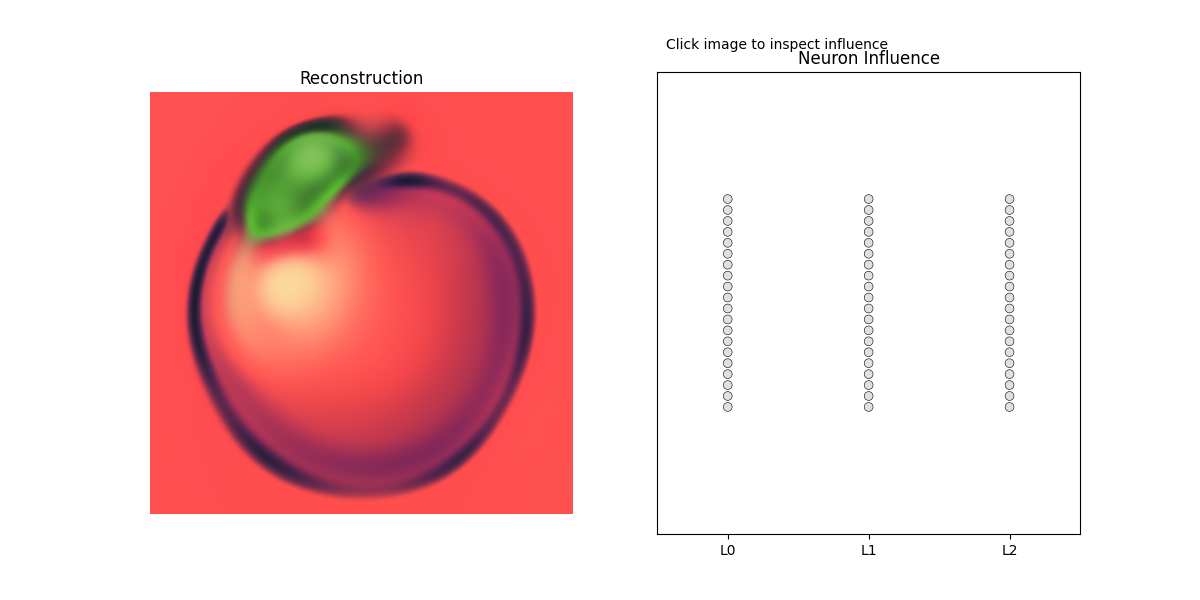

In [14]:
%load_ext ipympl
%matplotlib widget
launch_interactive_inspector(model, coords, (height, width))

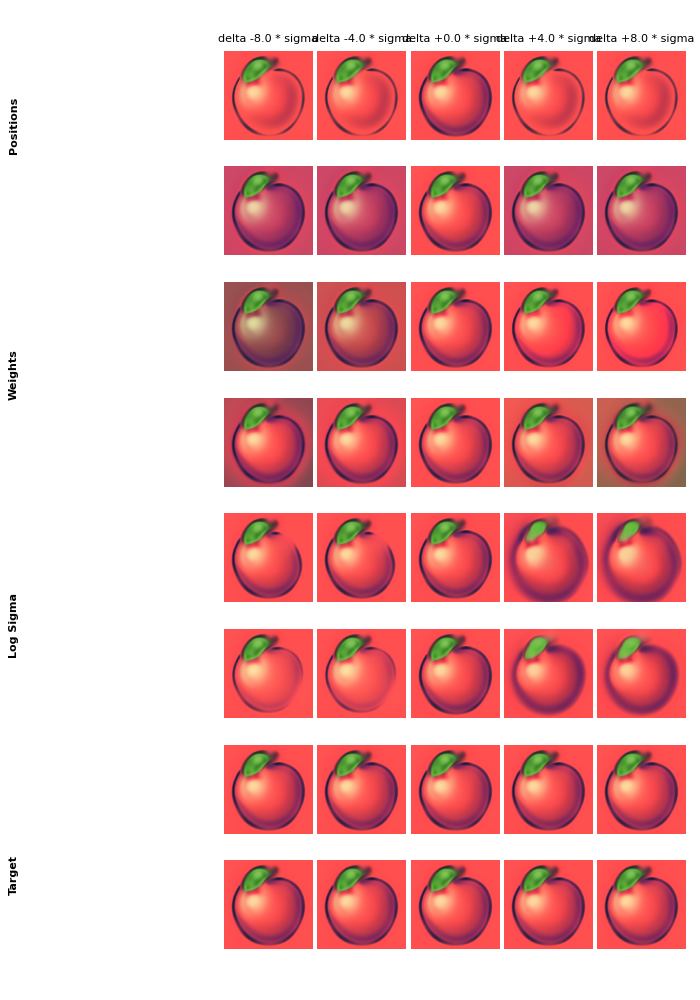

In [23]:
import random
import numpy as np
import matplotlib.pyplot as plt

param_groups = {
    "positions": [],
    "weights": [],
    "log_sigma": [],
    "target": [],
    "other": [],
}

for name, param in model.named_parameters():
    if param is None or param.numel() == 0:
        continue
    shape = param.shape
    for flat_idx in range(param.numel()):
        multi_idx = np.unravel_index(flat_idx, shape)
        group_key = next((key for key in param_groups if key != "other" and key in name), "other")
        param_groups[group_key].append(
            {
                "name": name,
                "param": param,
                "index": multi_idx,
                "group": group_key,
            }
        )

selected_entries = []
group_spans = []
group_order = ["positions", "weights", "log_sigma", "target", "other"]
per_group = 2
rng = random.Random(1)

for group_name in group_order:
    entries = param_groups[group_name]
    if not entries:
        continue
    count = min(per_group, len(entries))
    picks = rng.sample(entries, count) if len(entries) > count else entries
    start = len(selected_entries)
    selected_entries.extend(picks)
    end = len(selected_entries)
    group_spans.append((group_name, start, end))

num_rows = len(selected_entries)
if num_rows == 0:
    raise RuntimeError("No parameters found for sweep.")

deltas = torch.linspace(-8.0, 8.0, steps=5)
num_cols = len(deltas)

all_params = torch.cat(
    [
        param.detach().flatten().cpu()
        for _, param in model.named_parameters()
        if param is not None and param.numel() > 0
    ]
)
global_std = float(all_params.std().item()) if all_params.numel() > 0 else 0.1
if global_std < 1e-8:
    global_std = 0.1
step_size = global_std

was_training = model.training
model.eval()

first_param = next(model.parameters())
eval_device = first_param.device
coords_eval = coords.to(eval_device)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.4 * num_cols, 1.25 * num_rows))

if num_rows == 1 and num_cols == 1:
    axes = np.array([[axes]])
elif num_rows == 1:
    axes = axes[np.newaxis, :]
elif num_cols == 1:
    axes = axes[:, np.newaxis]


def _format_index(idx):
    if len(idx) == 0:
        return ""
    return "[" + "]".join(str(i) for i in idx) + "]"

with torch.no_grad():
    for row_idx, entry in enumerate(selected_entries):
        param = entry["param"]
        param_data = param.data
        idx = tuple(entry["index"])
        base_value = float(param_data[idx].item())
        row_label = f"{entry['name']}{_format_index(idx)}"

        try:
            for col_idx, delta in enumerate(deltas):
                param_data[idx] = base_value + delta.item() * step_size
                recon = (
                    model(coords_eval)
                    .view(height, width, -1)
                    .detach()
                    .cpu()
                    .clamp(0.0, 1.0)
                    .numpy()
                )

                ax = axes[row_idx, col_idx]
                ax.imshow(recon, interpolation="nearest")
                ax.axis("off")

                if row_idx == 0:
                    ax.set_title(f"delta {delta.item():+0.1f} * sigma", fontsize=8)
        finally:
            param_data[idx] = base_value

        axes[row_idx, 0].set_ylabel(
            row_label, rotation=0, labelpad=16, fontsize=7, va="center"
        )
        axes[row_idx, 0].yaxis.set_label_position("left")

if was_training:
    model.train()

for group_name, start, end in group_spans:
    mid = (start + end - 1) / 2.0
    y = 1.0 - (mid + 0.5) / num_rows
    fig.text(
        0.02,
        y,
        group_name.replace("_", " " ).title(),
        rotation=90,
        va="center",
        ha="center",
        fontsize=8,
        fontweight="bold",
    )

plt.subplots_adjust(left=0.32, right=0.98, top=0.95, bottom=0.05, hspace=0.28, wspace=0.05)
plt.show()


